In [1]:
import numpy as np
import math as mt
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from tabulate import tabulate
from collections import deque, namedtuple, Counter
from tqdm import tqdm

### Задание 1

In [2]:
chains = np.array([
    [[1/4, 3/4, 0, 0],
     [1/2, 0, 1/2, 0],
     [0, 1/2, 0, 1/2],
     [0, 0, 3/4, 1/4]],
    
    [[2/9, 1/3, 0, 4/9],
     [4/9, 1/9, 0, 4/9],
     [2/9, 2/9, 2/9, 1/3],
     [2/9, 2/9, 4/9, 1/9]],
    
    [[0, 1/2, 0, 1/2],
     [1/3, 0, 2/3, 0],
     [0, 1/4, 0, 3/4],
     [1/4, 0, 3/4, 0]]
])

In [3]:
def stationary_distribution(chain):
    eigenvals, eigenvects = np.linalg.eig(chain.T)
    close_to_1_idx = np.isclose(eigenvals, 1)
    stat_vect = eigenvects[:, close_to_1_idx][:, 0]
    stat_distr = stat_vect / stat_vect.sum()
    return stat_distr

In [4]:
for i, chain in enumerate(chains, 1):
    stat_distr = stationary_distribution(chain)
    with np.printoptions(formatter={'all': lambda x: str(Fraction(x).limit_denominator())}):
        print(f"Стационарное распределение {i} цепи: {stat_distr}")
    for k in [5, 10, 20, 30, 50]:
        print(f"pow = {k}:")
        mat = np.linalg.matrix_power(chain, k)
        table = tabulate(mat, tablefmt="fancy_grid")
        print(f"{table}")    
        print()
    print('-' * 100 + '\n')

Стационарное распределение 1 цепи: [1/5 3/10 3/10 1/5]
pow = 5:
╒══════════╤══════════╤══════════╤══════════╕
│ 0.176758 │ 0.430664 │ 0.169922 │ 0.222656 │
├──────────┼──────────┼──────────┼──────────┤
│ 0.287109 │ 0.146484 │ 0.453125 │ 0.113281 │
├──────────┼──────────┼──────────┼──────────┤
│ 0.113281 │ 0.453125 │ 0.146484 │ 0.287109 │
├──────────┼──────────┼──────────┼──────────┤
│ 0.222656 │ 0.169922 │ 0.430664 │ 0.176758 │
╘══════════╧══════════╧══════════╧══════════╛

pow = 10:
╒══════════╤══════════╤══════════╤══════════╕
│ 0.223716 │ 0.254039 │ 0.345961 │ 0.176285 │
├──────────┼──────────┼──────────┼──────────┤
│ 0.169359 │ 0.369677 │ 0.230324 │ 0.23064  │
├──────────┼──────────┼──────────┼──────────┤
│ 0.23064  │ 0.230324 │ 0.369677 │ 0.169359 │
├──────────┼──────────┼──────────┼──────────┤
│ 0.176285 │ 0.345961 │ 0.254039 │ 0.223716 │
╘══════════╧══════════╧══════════╧══════════╛

pow = 20:
╒══════════╤══════════╤══════════╤══════════╕
│ 0.203941 │ 0.291415 │ 0.308585 │ 0.196

### Задание 2

In [5]:
chain = np.array([[1/3, 1/3, 1/3],
                  [3/4, 0, 1/4],
                  [1/2, 1/6, 1/3]])
n = chain.shape[0]
stat_distr = stationary_distribution(chain)
stat_distr

array([0.47368421, 0.21052632, 0.31578947])

[0.4787 0.2097 0.3116]


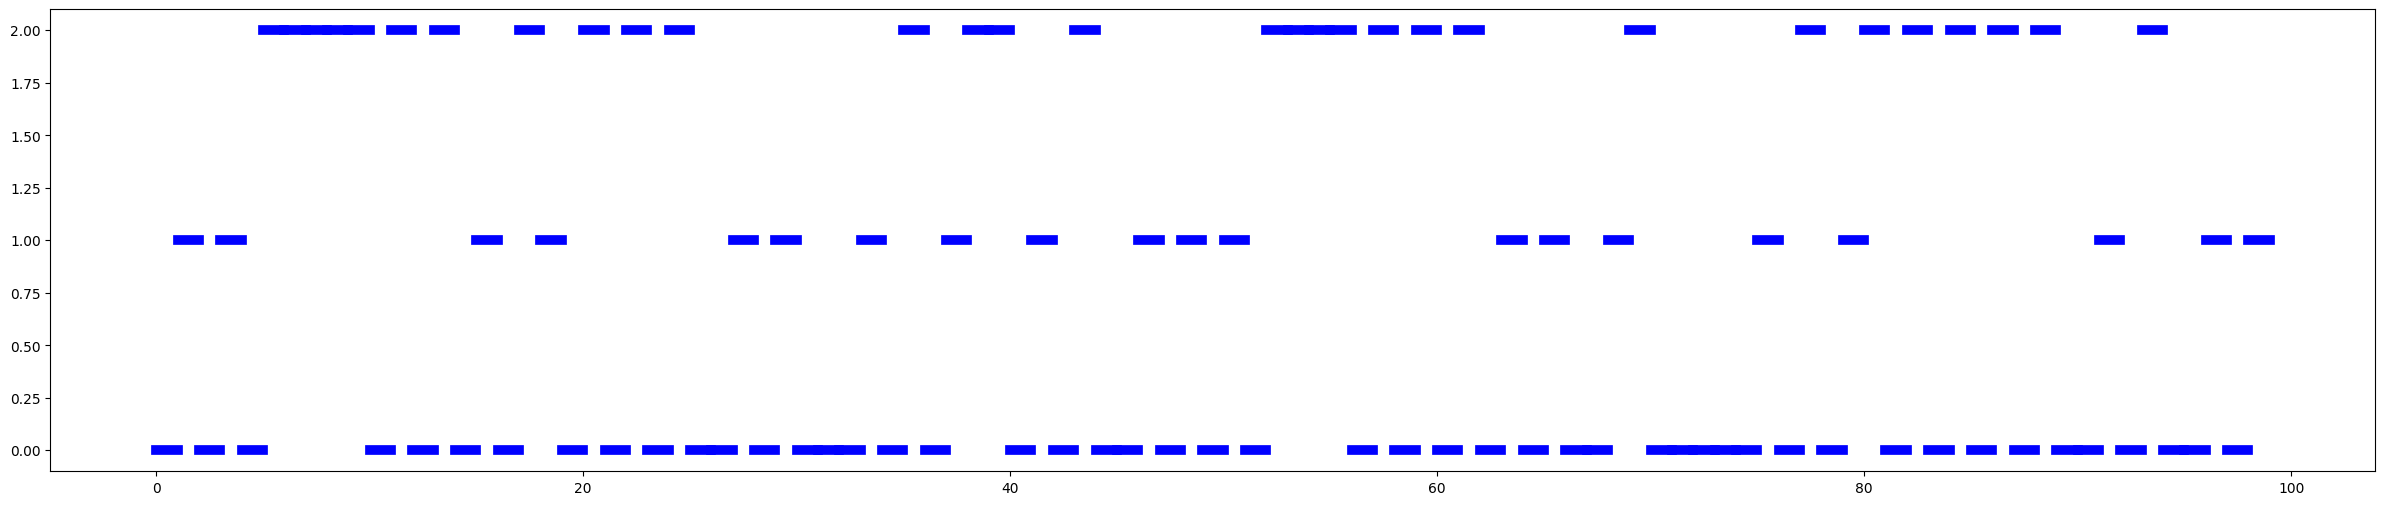

In [6]:
STEPS, STEPS_PLOT = 10_000, 100
plt.figure(figsize=(30, 6))
trip = np.zeros(STEPS, dtype=int)
for i in range(STEPS - 1):
    trip[i + 1] = np.random.choice(n, p=chain[trip[i]])
print(np.bincount(trip, minlength=n) / STEPS)
for i in range(STEPS_PLOT - 1):
    plt.plot([i, i + 1], [trip[i], trip[i]], c='b', lw=7)

In [7]:
K = 1000
STEPS = 10_000
cnt = np.ones(K, dtype=int)
tau = np.zeros(K, dtype=int)
for i in tqdm(range(K)):
    cur = 0
    for step in range(1, STEPS):
        cur = np.random.choice(n, p=chain[cur])
        if cur == 0:
            if tau[i] == 0:
                tau[i] = step
            cnt[i] += 1

100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 14.95it/s]


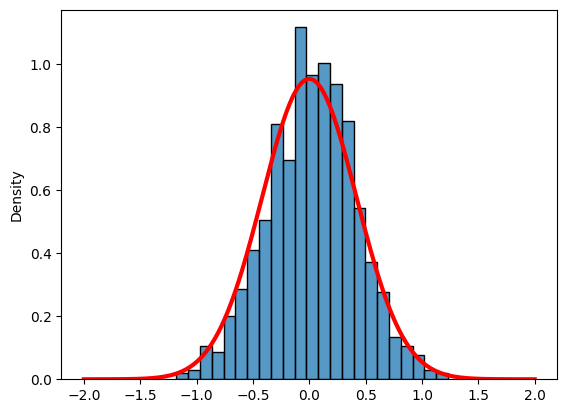

In [8]:
t = STEPS**0.5 * (cnt / STEPS - stat_distr[0])
var = stat_distr[0]**3 * np.var(tau, ddof=1)
sns.histplot(t, stat="density");
xs = np.linspace(-2, 2, 400)
ys = st.norm(0, var**0.5).pdf(xs)
plt.plot(xs, ys, c='r', lw=3);

### Задание 3

In [9]:
with open("MarkovChain.txt", 'r') as file:
    chain = []
    for line in file.readlines():
        row = list(map(float, line.split(';')))
        chain.append(row)
chain = np.array(chain)
n = chain.shape[0]
chain.shape

(50, 50)

In [10]:
class_id = 0
state_class = [-1] * n
g = []

def dfs(v):
    state_class[v] = class_id
    if v not in g[class_id]:
        g[class_id][v] = []
    for to in range(n):
        if chain[v][to]:
            g[class_id][v].append(to)
            if state_class[to] == -1:
                dfs(to)

In [11]:
for i in range(n):
    if state_class[i] == -1:
        g.append(dict())
        dfs(i)
        class_id += 1

In [12]:
dist = [-1] * n

def bfs(s):
    c = state_class[s]
    q = deque()
    q.append(s)
    dist[s] = 0
    while q:
        v = q.popleft()
        for to in g[c][v]:
            if dist[to] == -1:
                dist[to] = dist[v] + 1
                q.append(to)

In [13]:
for i, comp in enumerate(g):
    s = next(iter(comp))
    bfs(s)
    d = 0
    for fr in comp:
        for to in comp[fr]:
            val = dist[fr] - dist[to] + 1
            if val:
                d = mt.gcd(d, val)
    print(f"Период неразложимого класса #{i} равен d = {d}. Разбиение на группы по периоду:")
    result = [[] for _ in range(d)]
    for v in comp:
        result[dist[v] % d].append(v)
    for i in range(d):
        print(f"\tГруппа #{i}: {result[i]}")

Период неразложимого класса #0 равен d = 2. Разбиение на группы по периоду:
	Группа #0: [0]
	Группа #1: [37]
Период неразложимого класса #1 равен d = 4. Разбиение на группы по периоду:
	Группа #0: [1, 14, 26, 28, 30]
	Группа #1: [5, 9, 11, 20, 25, 43]
	Группа #2: [2, 7, 13, 19, 27, 32, 33, 34, 42]
	Группа #3: [10, 12, 15, 21, 29, 35, 44, 47, 49]
Период неразложимого класса #2 равен d = 3. Разбиение на группы по периоду:
	Группа #0: [3]
	Группа #1: [17]
	Группа #2: [48]
Период неразложимого класса #3 равен d = 3. Разбиение на группы по периоду:
	Группа #0: [4]
	Группа #1: [16, 46]
	Группа #2: [18, 22, 41]
Период неразложимого класса #4 равен d = 2. Разбиение на группы по периоду:
	Группа #0: [6, 8, 23, 38]
	Группа #1: [24, 36, 40, 45]
Период неразложимого класса #5 равен d = 2. Разбиение на группы по периоду:
	Группа #0: [31]
	Группа #1: [39]


### Задание 4

In [14]:
chain = np.array(
    [[0, 0, 1/2, 1/2],
     [0, 0, 0, 1],
     [1/2, 0, 0, 1/2],
     [1/3, 1/3, 1/3, 0]]
)
n = chain.shape[0]
stat_distr = stationary_distribution(chain)
stat_distr

array([0.25 , 0.125, 0.25 , 0.375])

### Задание 5

In [15]:
def ret_prob(steps, N = 10_000, STOP = 1_000_000):
    k, dim = steps.shape
    cnt = 0
    for _ in tqdm(range(N)):
        trip = steps[np.random.choice(k, STOP)]
        trip = np.cumsum(trip, axis=0)
        if np.any(np.all(trip == 0, axis=1)):
            cnt += 1
    return cnt / N

In [27]:
ret_prob(np.array([[-1], [1]]), STOP=100_000)

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1260.84it/s]


0.9976

In [17]:
ret_prob(np.array([[1, 0], [0, 1], [-1, 0], [0, -1]]))

100%|█████████████████████████████████████| 10000/10000 [04:02<00:00, 41.28it/s]


0.8135

In [18]:
ret_prob(np.array([[1, 0, 0], [0, 1, 0], [-1, 0, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]))

100%|█████████████████████████████████████| 10000/10000 [05:28<00:00, 30.44it/s]


0.3338

### Задание 6

$H_0: X_2, \ldots, X_n$ - н.о.р.


$H_1: X_2, \ldots, X_n$ - о.ц.м., стартовавшая из $X_1$

In [109]:
def wilks(X, n_states):
    WilksResult = namedtuple('WilksResult', [
        'statistic',
        'pvalue'
    ])
    k, n = X.shape
    # H_0
    stat_0 = np.zeros(k)
    for i, samp in enumerate(X):
        d = Counter(samp[1:])
        for cnt in d.values():
            stat_0[i] += cnt * mt.log(cnt / (n - 1))
    # H_1
    stat_1 = np.zeros(k)
    for i, samp in enumerate(X):
        d = dict()
        for j in range(n - 1):
            if samp[j] not in d:
                d[samp[j]] = []
            d[samp[j]].append(samp[j + 1])
        for lst in d.values():
            c = Counter(lst)
            for cnt in c.values():
                stat_1[i] += cnt * mt.log(cnt / len(lst))
    stat = 2 * (stat_1 - stat_0)
    pval = 1 - st.chi2((n_states - 1)**2).cdf(stat)
    res = WilksResult(stat, pval)
    return res

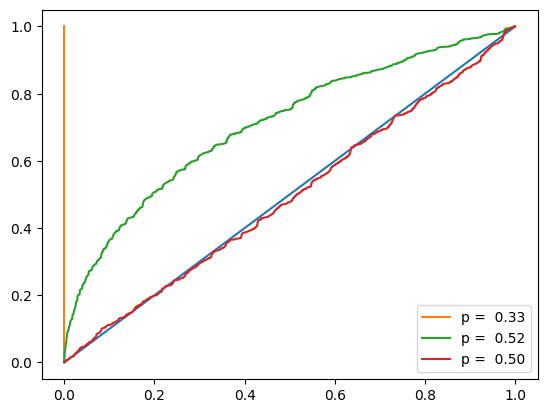

In [110]:
K = 1_000
N = 1_000

unisplit = np.arange(1, K + 1) / K
plt.plot([0, 1], [0, 1])
for p in [0.33, 0.52, 0.5]:
    X = st.bernoulli(1 - p).rvs((K, N))
    X = np.logical_xor.accumulate(X, axis=1)
    pvals = wilks(X, 2).pvalue
    pvals = np.sort(pvals)
    plt.plot(pvals, unisplit, label=f"p = {p: .2f}")
plt.legend();